<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 16 - Prevendo a Média Mensal de Vendas - Modelo ARIMA</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br

**Modelos de Média Móvel Integrada Auto-Regressiva (ARIMA - Autoregressive Integrated Moving Average Models )**

ARIMA (p, d, q)

O ARIMA é uma extensão natural da classe de modelos ARMA, que pode reduzir uma série não estacionária a uma série estacionária usando uma sequência de diferenças.

Uma série temporal x(t) é integrada na ordem d se diferenciar a série "d vezes", resultar em uma série discreta de ruído branco.

Uma série temporal x(t) é o modelo ARIMA (p, d, q) se a série diferir d vezes e, em seguida, seguir um processo ARMA (p, q).

Vamos simular um modelo ARIMA para nosso problema de negócio e verificar se conseguimos uma performance melhor do que tivemos com o modelo ARMA.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [ ]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [ ]:
# Instala o plotly
#!pip install -q plotly

In [ ]:
# O comando abaixo instala o plotly-orca para gráficos interativos
# Se necessário, reinicie o Jupyter Notebook
# https://github.com/plotly/orca
# Não funciona no Google Colab, a menos que você instale o mini-conda no Google Colab. Pesquise sobre como fazer isso.
# !conda install -y -c plotly plotly-orca

Solving environment: done

# All requested packages already installed.



In [ ]:
# O statsmodels deve ser atualizado
#!pip install -q -U statsmodels

In [83]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
matplotlib.style.use('ggplot')
%matplotlib inline

In [84]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

sklearn         0.23.1
statsmodels     0.11.1
matplotlib      3.3.0
numpy           1.16.6
scipy           1.4.1
pandas          1.0.5
statsmodels.api 0.11.1
plotly          4.8.2
seaborn         0.10.1
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [97]:
# Carrega os dados
dados = pd.read_csv("./data/AIH.csv")
dados['Data'] = pd.to_datetime(dados.Data, format = '%d/%m/%Y')
dados = dados.set_index('Data')

In [98]:
# Shape
dados.shape

(3896, 1)

In [99]:
# Colunas
dados.columns

Index(['QT_INTER'], dtype='object')

### Análise Exploratória

In [100]:
# Visualizando os dados
dados.head()

,QT_INTER
Data,
2010-01-01,670
2010-01-02,671
2010-01-03,708
2010-01-04,1463
2010-01-05,1424


In [89]:
# Resumo estatístico
dados.describe()

,QT_INTER
count,3926.000000
mean,1332.552471
std,386.656503
min,42.000000
25%,912.000000
50%,1426.500000
75%,1644.000000
max,2241.000000


In [90]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3926 entries, 2010-01-01 to 2020-09-30
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   QT_INTER  3926 non-null   int64
dtypes: int64(1)
memory usage: 61.3 KB


In [104]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [105]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [106]:
# Conferindo
dados.columns

Index(['qt_inter'], dtype='object')

In [92]:
# Vamos checar os valores únicos por coluna (para ajudar a definir se a variável é categórica ou não)
for c in dados.columns:
    if len(set(dados[c])) < 20:
        print(c,set(dados[c]))

In [21]:
# Vamos checar as categorias de itens
a = dados['category'].value_counts()
fig = px.bar(a, x = a.index, y = a.values, height = 400)
fig.update_layout(title = {'text': "Categorias de Itens", 
                           'y':0.9,'x':0.5,'xanchor': 
                           'center','yanchor': 'top'},
                  xaxis_title = "Categoria",
                  yaxis_title = "Total de Itens")
fig.show(renderer = 'svg')

KeyError: 'category'

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [15]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [16]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

In [107]:
# Como está ficando cada dataset?
ts_tecnologia = dados
ts_tecnologia

,qt_inter
Data,
2010-01-01,670
2010-01-02,671
2010-01-03,708
2010-01-04,1463
2010-01-05,1424
...,...
2020-08-27,1200
2020-08-28,1067
2020-08-29,674


In [102]:
# Como está ficando cada dataset?
ts_tecnologia

,QT_INTER
Data,
2010-01-01,670
2010-01-02,671
2010-01-03,708
2010-01-04,1463
2010-01-05,1424
...,...
2020-08-27,1200
2020-08-28,1067
2020-08-29,674


Vamos mover a data para o índice e assim criar a série temporal.

In [18]:
# Colocando a data como índice
#ts_tecnologia = ts_tecnologia.set_index('order_date')
ts_tecnologia

In [19]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

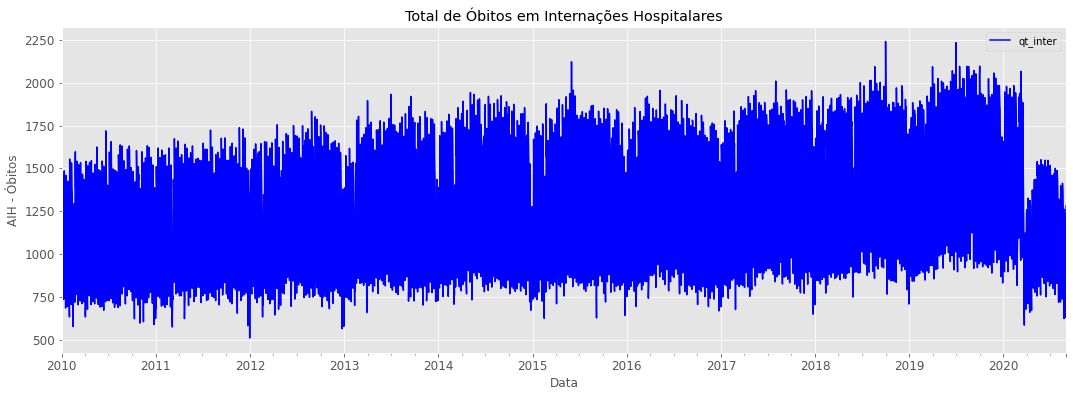

In [108]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['qt_inter']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('AIH - Óbitos')
plt.title("Total de Óbitos em Internações Hospitalares")
plt.show()

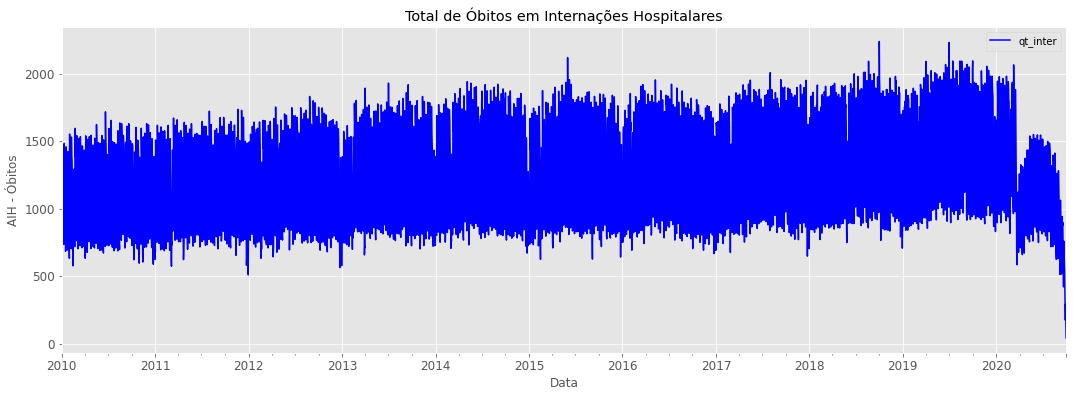

In [94]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['qt_inter']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('AIH - Óbitos')
plt.title("Total de Óbitos em Internações Hospitalares")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [32]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [25]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [26]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [23]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [109]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['qt_inter'].resample('MS').mean()

In [110]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [111]:
# Checando os dados
media_vendas_tecnologia

Data
2010-01-01    1079.193548
2010-02-01    1112.250000
2010-03-01    1193.580645
2010-04-01    1131.000000
2010-05-01    1157.193548
                 ...     
2020-04-01    1084.800000
2020-05-01    1209.032258
2020-06-01    1284.333333
2020-07-01    1257.516129
2020-08-01    1088.870968
Freq: MS, Name: qt_inter, Length: 128, dtype: float64

In [26]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

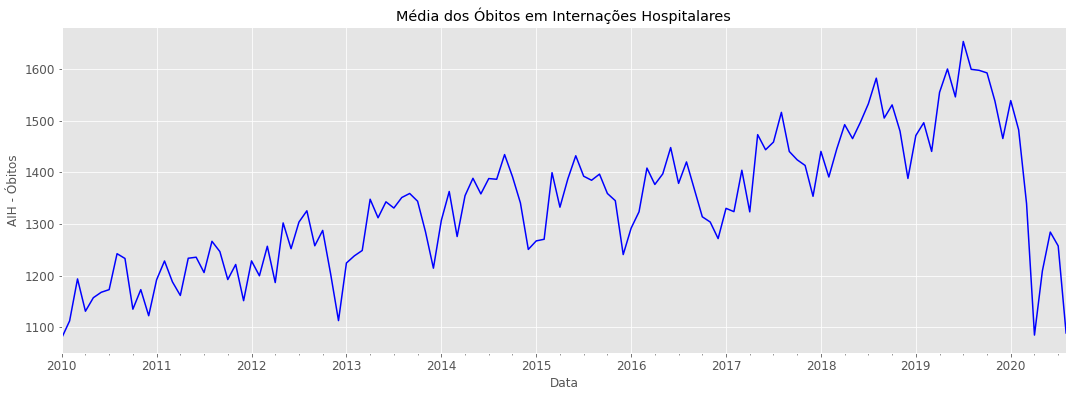

In [112]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data")
plt.ylabel('AIH - Óbitos')
plt.title("Média dos Óbitos em Internações Hospitalares")
plt.show()

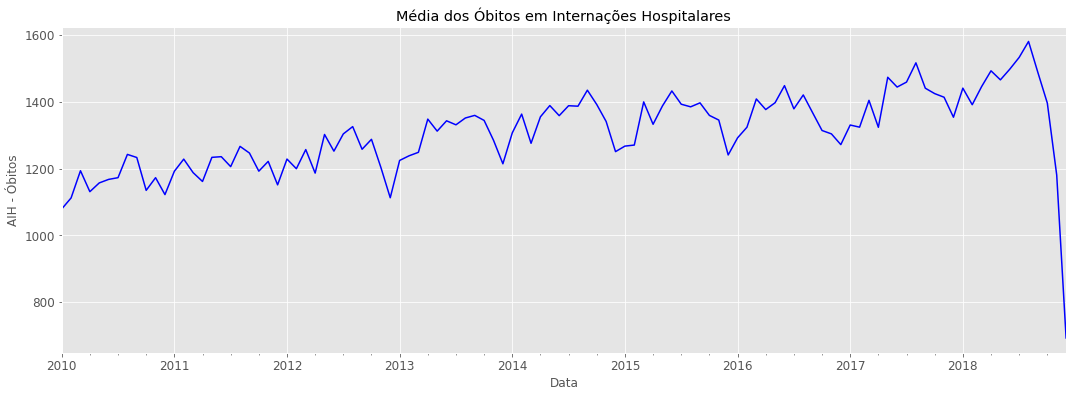

In [36]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data")
plt.ylabel('AIH - Óbitos')
plt.title("Média dos Óbitos em Internações Hospitalares")
plt.show()

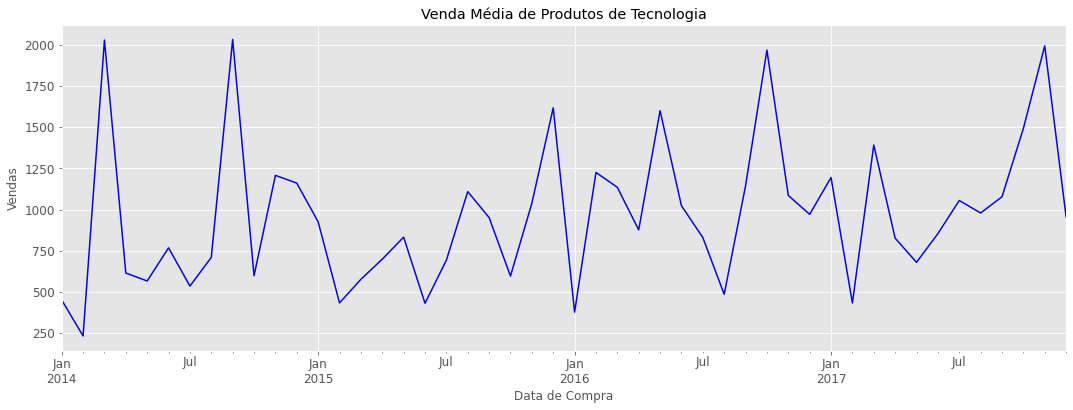

In [27]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

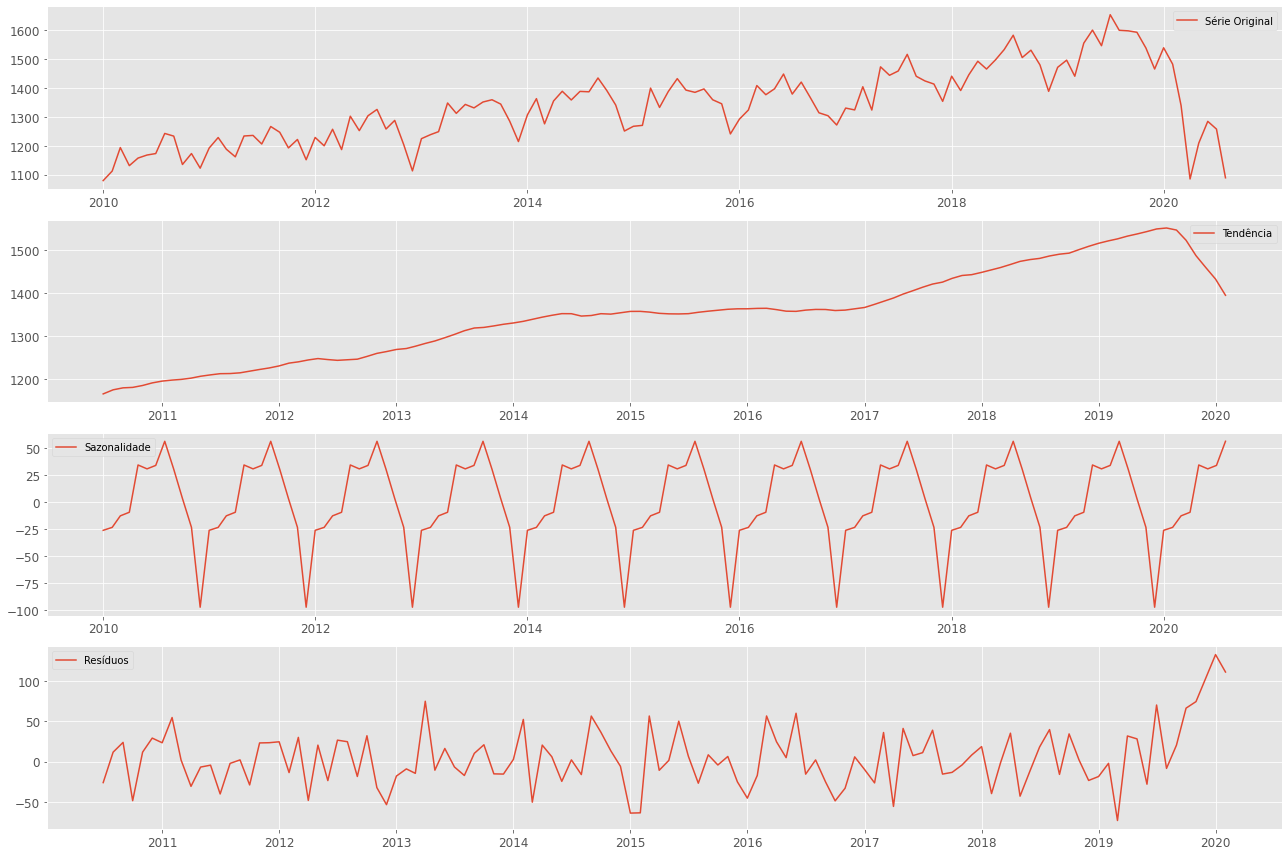

In [114]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

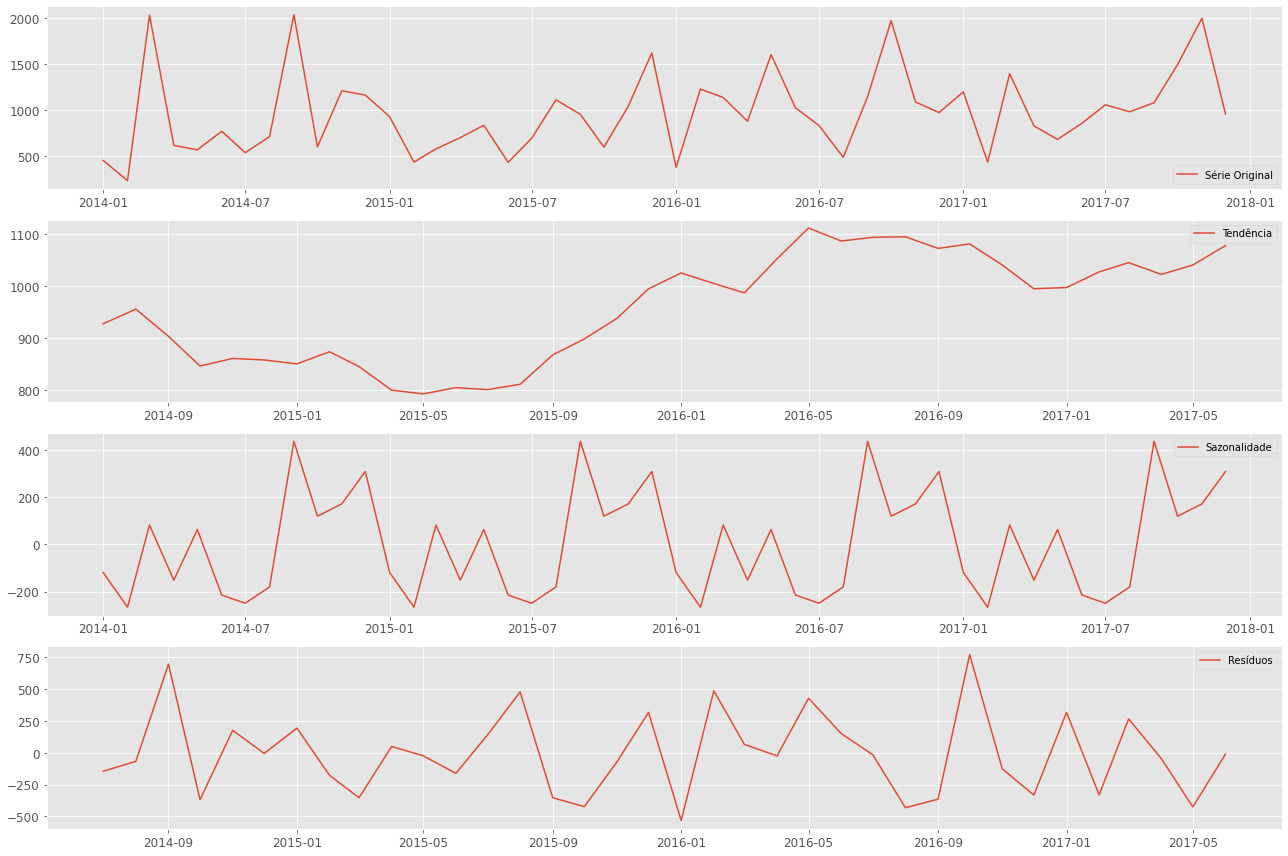

In [28]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [115]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

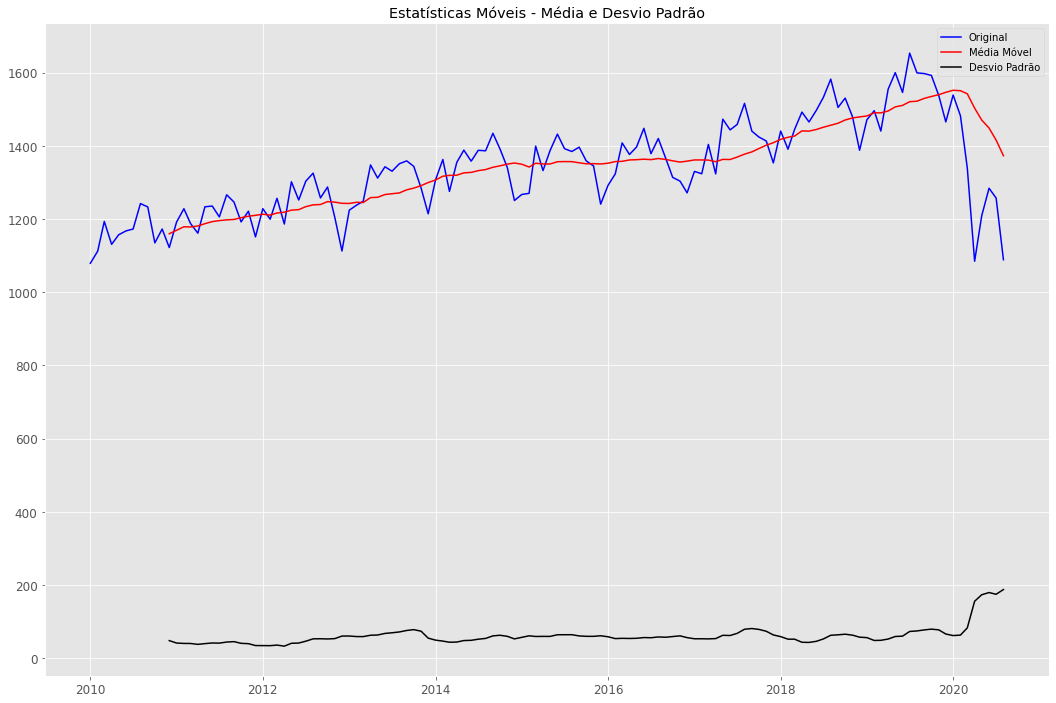


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.476542
Valor-p                           0.121287
Número de Lags Consideradas       1.000000
Número de Observações Usadas    126.000000
Valor Crítico (1%)               -3.483346
Valor Crítico (5%)               -2.884766
Valor Crítico (10%)              -2.579156
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [117]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

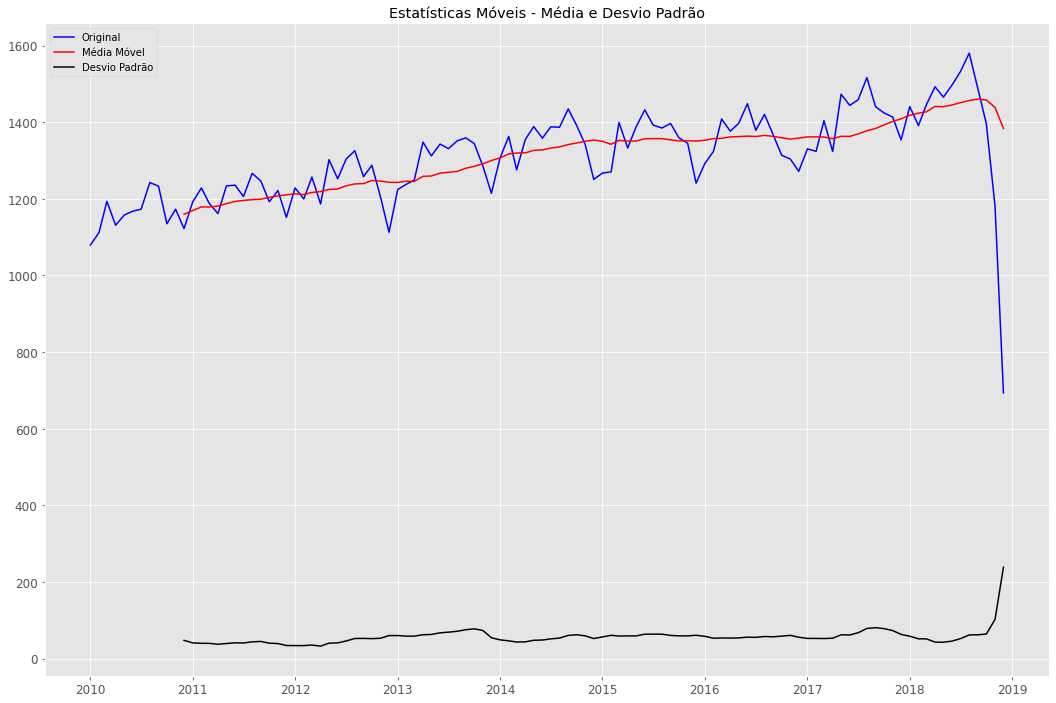


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.800034
Valor-p                           0.058269
Número de Lags Consideradas       3.000000
Número de Observações Usadas    104.000000
Valor Crítico (1%)               -3.494850
Valor Crítico (5%)               -2.889758
Valor Crítico (10%)              -2.581822
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [40]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

In [118]:
# Divisão em treino e teste
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

In [119]:
trainset

Data
2010-01-01    1079.193548
2010-02-01    1112.250000
2010-03-01    1193.580645
2010-04-01    1131.000000
2010-05-01    1157.193548
                 ...     
2017-08-01    1516.225806
2017-09-01    1440.400000
2017-10-01    1424.225806
2017-11-01    1413.400000
2017-12-01    1353.612903
Freq: MS, Name: qt_inter, Length: 96, dtype: float64

In [120]:
len(trainset)

96

In [121]:
len(testset)

32

### Função Para o Cálculo da Acurácia

In [122]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

## Modelo ARIMA

Antes de criar o modelo ARIMA, vamos aplicar o conceito de Grid Search para encontrar a melhor combinação de valores para os parâmetros p, d e q.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

### Grid Search Para os Parâmetros p, d e q

In [123]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(method = 'mle', disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions)
    return error

In [124]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = avalia_modelo_arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE = %.3f' % (order, mse))
                except:
                    continue

    print('\nMelhor Modelo ARIMA%s MSE = %.3f' % (best_cfg, best_score))

In [125]:
# Valores para o grid
p_values = [0, 1, 2]
d_values = [0, 1, 2] 
q_values = [0, 1, 2] 

In [126]:
# Testando o melhor valor de p, d e q
avalia_melhor_arima(media_vendas_tecnologia.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE = 38202.523
ARIMA(0, 0, 1) MSE = 17648.116
ARIMA(0, 0, 2) MSE = 16416.916
ARIMA(0, 1, 0) MSE = 7395.198
ARIMA(0, 1, 1) MSE = 7784.585
ARIMA(0, 1, 2) MSE = 8365.477
ARIMA(0, 2, 0) MSE = 14831.231
ARIMA(0, 2, 1) MSE = 7405.991
ARIMA(0, 2, 2) MSE = 7704.975
ARIMA(1, 0, 0) MSE = 7395.039
ARIMA(1, 0, 1) MSE = 7604.293
ARIMA(1, 0, 2) MSE = 7972.713
ARIMA(1, 1, 0) MSE = 7895.208
ARIMA(1, 1, 1) MSE = 9722.238
ARIMA(1, 2, 0) MSE = 13132.244
ARIMA(2, 0, 0) MSE = 7736.689
ARIMA(2, 0, 1) MSE = 7756.923
ARIMA(2, 1, 0) MSE = 7893.214
ARIMA(2, 1, 1) MSE = 8647.107
ARIMA(2, 1, 2) MSE = 9098.107
ARIMA(2, 2, 0) MSE = 11753.849

Melhor Modelo ARIMA(1, 0, 0) MSE = 7395.039


As mensagens de warning acima indicam que as algumas combinações testadas não fazem o modelo nem mesmo convergir.

De acordo com o resultado, os melhores valores são: order = (6,0,2). Vamos então criar o modelo.

In [127]:
# Cria o modelo
modelo_arima = ARIMA(trainset, order = (1,0,0))

In [128]:
# Treina o modelo
modelo_arima_fit = modelo_arima.fit(method = 'mle', disp = False)

In [129]:
# Sumário do modelo
modelo_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               qt_inter   No. Observations:                   96
Model:                     ARMA(1, 0)   Log Likelihood                -521.720
Method:                           mle   S.D. of innovations             55.118
Date:                Mon, 23 Nov 2020   AIC                           1049.440
Time:                        12:36:40   BIC                           1057.133
Sample:                    01-01-2010   HQIC                          1052.549
                         - 12-01-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1290.3671     32.158     40.126      0.000    1227.339    1353.395
ar.L1.qt_inter     0.8328      0.059     14.214      0.000       0.718       0.948
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2008           +0.0000j            1.2008            0.0000
-----------------------------------------------------------------------------
"""

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

In [130]:
media_vendas_tecnologia

Data
2010-01-01    1079.193548
2010-02-01    1112.250000
2010-03-01    1193.580645
2010-04-01    1131.000000
2010-05-01    1157.193548
                 ...     
2020-04-01    1084.800000
2020-05-01    1209.032258
2020-06-01    1284.333333
2020-07-01    1257.516129
2020-08-01    1088.870968
Freq: MS, Name: qt_inter, Length: 128, dtype: float64

In [135]:
# Previsões com o modelo (passamos somente as datas e o modelo prevê os valores)
arima_predict = modelo_arima_fit.predict(start = pd.to_datetime('2018-01-01'), 
                                         end = pd.to_datetime('2020-08-01'),
                                         dynamic = False)

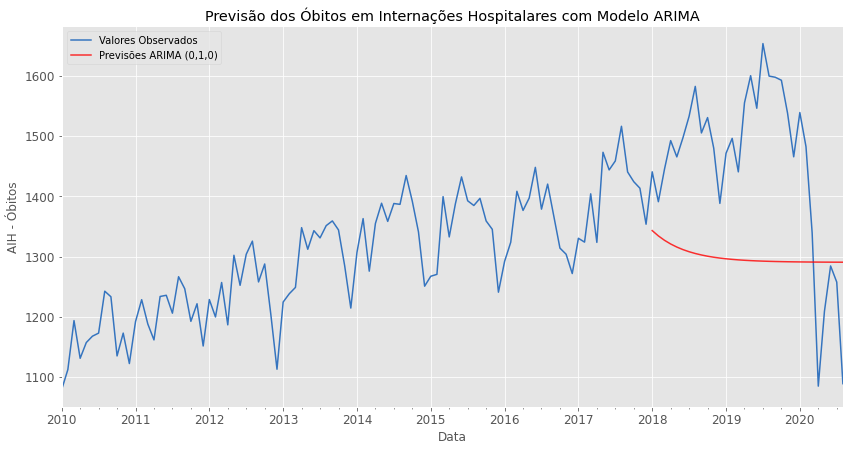

In [136]:
# Vamos fazer previsão de um passo a frente
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#3574BF')
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax = ax, label = 'Previsões ARIMA (0,1,0)', alpha = 0.8, color = 'red') 
plt.title('Previsão dos Óbitos em Internações Hospitalares com Modelo ARIMA')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend()
plt.show()

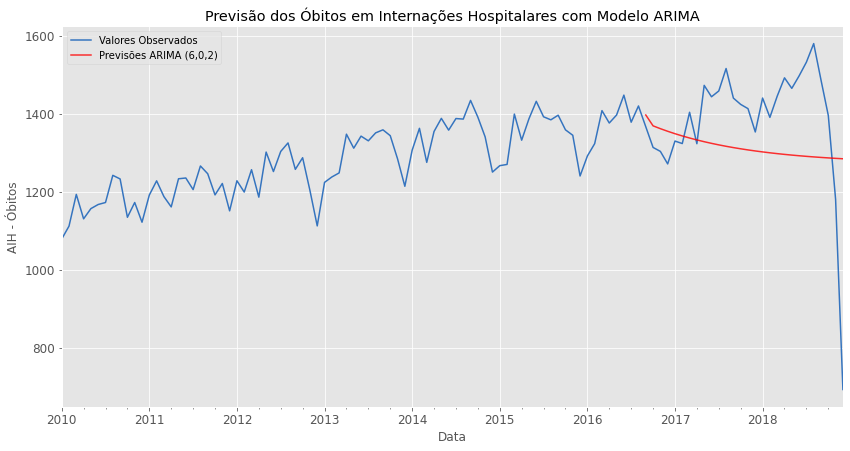

In [71]:
# Vamos fazer previsão de um passo a frente
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#3574BF')
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax = ax, label = 'Previsões ARIMA (6,0,2)', alpha = 0.8, color = 'red') 
plt.title('Previsão dos Óbitos em Internações Hospitalares com Modelo ARIMA')
plt.xlabel('Data')
plt.ylabel('AIH - Óbitos')
plt.legend()
plt.show()

In [137]:
# Calculando a performance
arima_results = performance(testset, arima_predict)
arima_results

MSE das previsões é 43347.36
RMSE das previsões é 208.2
MAPE das previsões é 12.74


Vamos executar alguns diagnósticos para avaliar o modelo.

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [50]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\nOs resíduos podem não ser normalmente distribuídos.')
else:
    print ('\nOs resíduos parecem normalmente distribuídos.')


Os resíduos parecem normalmente distribuídos.


In [51]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.9240282]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto, um modelo ARIMA (6,0,2) fornece um bom ajuste do modelo.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA (1,1) - AIC = 550.3 e RMSE = 420.2
- Aula 16 --> Modelo ARIMA (6,0,2) - AIC = 559.4 e RMSE = 401.5

Com o modelo ARIMA conseguimos reduzir o erro total do modelo, embora o AIC tenha aumentado um pouco. 

O modelo ARIMA consegue um ajuste aos dados, mas não é muito melhor que o modelo ARMA.

Vamos ver o que conseguimos com um modelo mais avançado, o SARIMA. Na próxima aula.

# Fim